In [1]:
%cd ~/programs/critic-llm/
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import jax.numpy as jnp
import jax
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rho_plus as rp

is_dark = True
theme, cs = rp.mpl_setup(is_dark)

/home/nicholas/programs/critic-llm


In [85]:
from critic import load_llama_corrector
from critic.simple_corrector import UniformCorrector
corrector = load_llama_corrector(n_threads=4, new_kbd=False, kbd_weight=1)

llama_new_context_with_model: n_ctx_per_seq (256) < n_ctx_train (131072) -- the full capacity of the model will not be utilized


In [7]:
just_lm = load_llama_corrector()
just_lm.base = UniformCorrector()

llama_new_context_with_model: n_ctx_per_seq (256) < n_ctx_train (131072) -- the full capacity of the model will not be utilized


In [53]:
df = pd.read_feather('precomputed/all_typos.feather')
print(df.shape)
df.head()

(35551, 12)


,kind,corrected,participant,weight,p,t,ist,i,j,context,wrong_char,right_char
0,omission,False,469,1.0,Can you help get this cleared up?,Can you help get th¬s cleared up?,Can you help get th␣s cleared up?,19,NaN,Can you help get this,s,i
1,substitute,True,469,1.0,Can you help get this cleared up?,Can you help get th¬s cleared up?,Can you help get th␣s cleared up?,20,19.0,Can you help get this c,␣,s
2,omission,False,469,1.0,Doctors gave him 10 years ␣␣␣␣␣␣␣␣␣␣␣␣to live ...,Doctors gave him 10 years¬␣␣␣␣␣␣␣␣␣␣␣␣to live ...,Doctors gave him 10 years␣ t liv␈␈␈␈␈␈to live ...,25,NaN,Doctors gave him 10 years to,t,
3,insertion,True,469,1.0,Doctors gave him 10 years ␣␣␣␣␣␣␣␣␣␣␣␣to live ...,Doctors gave him 10 years¬␣␣␣␣␣␣␣␣␣␣␣␣to live ...,Doctors gave him 10 years␣ t liv␈␈␈␈␈␈to live ...,25,NaN,Doctors gave him 10 years to,␣,t
4,insertion,True,469,1.0,Doctors gave him 10 years ␣␣␣␣␣␣␣␣␣␣␣␣to live ...,Doctors gave him 10 years¬␣␣␣␣␣␣␣␣␣␣␣␣to live ...,Doctors gave him 10 years␣ t liv␈␈␈␈␈␈to live ...,26,NaN,Doctors gave him 10 years to,,t


In [73]:
last = df.groupby('p').last().reset_index()
prompts = last['p']
text = last['t']

def clean(series):
    return series.str.replace('␣', '').str.replace('¬', '')

last['p_clean'] = clean(prompts)
last['t_clean'] = clean(text)


clean = last[last['p_clean'].str.lower() != last['t_clean'].str.lower()][['p_clean', 't_clean']]

valid = clean[clean['p_clean'].str.count(' ') == clean['t_clean'].str.count(' ')]
valid[valid['p_clean'].str.contains('could be')]

/tmp/ipykernel_2406936/959341736.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  last = df.groupby('p').last().reset_index()


,p_clean,t_clean
3935,"If the Penskes have any luck at all, they coul...","If the Penskes have any luck as all, they coul..."
3939,"If the Penskes have any luck at all, they coul...","If the Penskes have any luck at all, tey could..."
3941,"If we don't get it, could be trouble.","If we don't get it, could be trouble"
3945,"If we don't get it, could be trouble.","If we do't get it, could be trouble."
3947,"If we don't get it, could be trouble.","If we dont get it, could be trouble."


In [86]:
import pickle
from dataclasses import dataclass
from time import perf_counter
from tqdm import tqdm
from string import ascii_lowercase

from critic.corrector import Corrections
from critic.kbd_layout import QWERTY
from critic.simple_corrector import SimpleCorrector, UniformCorrector

@dataclass
class CorrectionResult:
    true: str
    typed: str
    corrs: Corrections
    context: str
    time: float


def evaluate(corrector, path):
    results = []
    data = valid[::20]
    for i, row in tqdm(data.iterrows(), total=data.shape[0]):
        corrector.clear_context()
        context = ''

        p_words = row['p_clean'].split(' ')
        t_words = row['t_clean'].split(' ')

        for true, typed in zip(p_words, t_words):
            if all(c.lower() in ascii_lowercase for c in true + typed):
                start = perf_counter()
                corrs = corrector.correct(typed)
                end = perf_counter()
                results.append(CorrectionResult(true, typed, corrs, context, end - start))

            corrector.push_word(true)
            context += true + ' '

    print(len(results))

    with open(f'results/{path}.pkl', 'wb') as f:
        pickle.dump(results, f)

    return results


opt_results = evaluate(corrector, 'optimized_probs')
# kbd_results = evaluate(corrector.base, 'kbd_probs')
# lm_results = evaluate(just_lm, 'lm_probs')
# corrector.base.model = old_mod
# evaluate(corrector, 'old_probs')

# simple = SimpleCorrector()
# simple_results = evaluate(simple, 'simple_probs')

100%|██████████| 179/179 [05:57<00:00,  2.00s/it]

1229


In [87]:
from typing import Sequence


def grade(res: CorrectionResult):
    corrs = res.corrs.as_series().sort_values(ascending=False)
    if res.true in corrs.index:
        data = {
            'prob': corrs[res.true],
            'rank': list(corrs.index).index(res.true) + 1
        }
    else:
        data = {
            'prob': 0,
            'rank': np.nan
        }

    data['error'] = res.true != res.typed
    data['correct'] = res.true == corrs.index[0]
    data['time'] = res.time

    return data

def grade_all(results: Sequence[CorrectionResult]):
    return pd.DataFrame([grade(res) for res in results])

res_df = grade_all(opt_results)
display(res_df.mean().round(3))
res_df

prob       0.876
rank       1.105
error      0.123
correct    0.923
time       0.291
dtype: float64

,prob,rank,error,correct,time
0,0.981879,1.0,False,True,0.506430
1,0.999154,1.0,False,True,0.484041
2,0.997758,1.0,False,True,0.298422
3,0.999930,1.0,False,True,0.090272
4,0.995520,1.0,False,True,0.338983
...,...,...,...,...,...
1224,0.999681,1.0,False,True,0.157044
1225,0.999283,1.0,False,True,0.163429
1226,0.926308,1.0,False,True,0.170882
1227,0.999673,1.0,False,True,0.409232


In [88]:
grade_dfs = []

for path, name in [    
    ('optimized_probs_new_kbd', 'new_kbd'),
    ('optimized_probs', 'LM + Keyboard'),
    ('kbd_probs', 'Keyboard Only'),
    ('lm_probs', 'LM Only')
]:
    with open(f'results/{path}.pkl', 'rb') as f:
        results = pickle.load(f)
        grades = grade_all(results)
        grades['model'] = name
        grade_dfs.append(grades)

grades = pd.concat(grade_dfs, axis=0).reset_index(names='i')
grades['in_list'] = ~pd.isna(grades['rank'])

display(pd.crosstab(grades['error'], grades['correct']))

display(grades.groupby('model').mean().round(3)[['prob', 'rank', 'correct', 'time']])
# display(grades.query('error').groupby('model').mean().round(2)[['prob', 'rank', 'correct']])

# with sns.plotting_context('talk'):
#     g = sns.displot(grades, x='prob', row='model', aspect=2)
#     g.set_titles('{row_name}')
#     for ax in g.axes.flatten():
#         rp.ylabel_top(ax=ax)

#     g = sns.displot(grades, x='rank', discrete=True, row='model')
#     for ax in g.axes.flatten():
#         rp.ylabel_top(ax=ax)

correct,False,True
error,,
False,220,4092
True,329,275


,prob,rank,correct,time
model,,,,
Keyboard Only,0.821,1.545,0.893,0.079
LM + Keyboard,0.876,1.105,0.923,0.291
LM Only,0.742,1.512,0.810,0.259
new_kbd,0.917,1.203,0.928,0.235


In [89]:
# thread_df = grades.query('model == "LM + Keyboard"').copy().drop(columns=['model'])
# thread_df['cores'] = 2
# res_df['cores'] = 1

# thread_df = pd.concat([thread_df, res_df])
# thread_df

# thread_df.groupby('cores').agg({'time': lambda x: np.mean(x > 0.8)}) * 100

# sns.boxplot(thread_df, x='time', hue='cores', palette='tab10')
# plt.suptitle('Seconds Per Word')

# critic = grades.query('model == "LM + Keyboard"')
# pd.crosstab(critic['error'], critic['correct'])

In [90]:
grades.query('in_list and error').groupby('model').mean().drop(columns=['i', 'in_list']).round(3)

,prob,rank,error,correct,time
model,,,,,
Keyboard Only,0.141,6.560,1.0,0.181,0.085
LM + Keyboard,0.748,1.655,1.0,0.776,0.335
LM Only,0.778,1.560,1.0,0.828,0.301
new_kbd,0.570,3.017,1.0,0.586,0.245


In [91]:
grades.pivot(index='i', columns='model', values='correct').query('`Keyboard Only` and not new_kbd')

model,Keyboard Only,LM + Keyboard,LM Only,new_kbd
i,,,,
567,True,False,False,False
1086,True,False,False,False
1189,True,False,False,False


In [92]:
with open('results/kbd_probs.pkl' , 'rb') as f:
    kbd = pickle.load(f)

with open('results/lm_probs.pkl' , 'rb') as f:
    lm = pickle.load(f)

len(kbd), len(lm)

(1229, 1229)

In [96]:
kbd[1189]

CorrectionResult(true='mechanised', typed='mechanised', corrs=Corrections(words=['mechanised', 'mechanized', 'mechanism', 'mechanistic', 'merchandised', 'mechanics', 'mechanize', 'machinist'], probs=array([5.75828005e-01, 4.17477216e-01, 4.22678311e-05, 5.88135245e-08,
       1.90509040e-06, 4.05786076e-04, 6.24476166e-03, 4.98145636e-14])), context='Northern forces had captured a southern ', time=0.06160583905875683)

In [98]:
lm[1189]

CorrectionResult(true='mechanised', typed='mechanised', corrs=Corrections(words=['mechanised', 'mechanized', 'mechanism', 'mechanistic', 'merchandised', 'mechanics', 'mechanize', 'machinist'], probs=array([2.83025081e-03, 6.11300945e-01, 3.25472940e-01, 9.74976475e-04,
       2.00014691e-04, 4.82666336e-02, 3.00361290e-04, 1.06538777e-02])), context='Northern forces had captured a southern ', time=0.5602793160360307)

In [51]:
valid

,p_clean,t_clean
0,1.5 million visitors will flood Atlanta each d...,1.5 million visitors will flood Atlanta each d...
1,1.5 million visitors will flood Atlanta each d...,1.5 million visitors will flood Atlanta each d...
10,2nd since so many people are out of the office...,2nd since so many people are out of the office...
11,2nd since so many people are out of the office...,2nd science so many peoples are out of the off...
12,A Hungarian neuro surgeon said that medical su...,A hungarian neuro surgeon sad that medical sup...
...,...,...
9974,Sounds good to me.,Sounds ood to me
9977,The filing concerns various scheduling and bal...,The filing concerns various scheduling and ala...
9978,Diplomats are predicting that the embargo will...,Diplomats are predicting the that embargo will...
9981,Thank you for all your help.,Thank you for all your help


In [39]:
from scipy.special import logit, softmax
from scipy.optimize import minimize_scalar

@np.vectorize
def objective(lm_w):    
    probs = []
    for r1, r2 in zip(kbd, lm):
        s1 = r1.corrs.as_series()
        s2 = r2.corrs.as_series().loc[s1.index]

        s3 = lm_w * logit(s1) + (1 - lm_w) * logit(s2)
        s3.iloc[:] = softmax(s3)
        probs.append(s3.to_dict().get(r1.true, 0))
    return np.mean(probs)

ww = np.linspace(0.1, 0.9, 7)
oo = objective(ww)

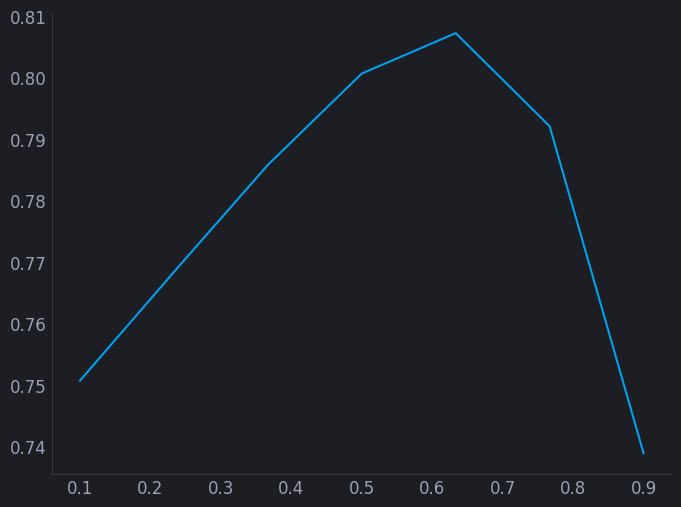

In [40]:
plt.plot(ww, oo)

In [29]:
min(p.shape[1] for p in probs)

3

/home/nmiklaucic/miniconda3/envs/llm/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


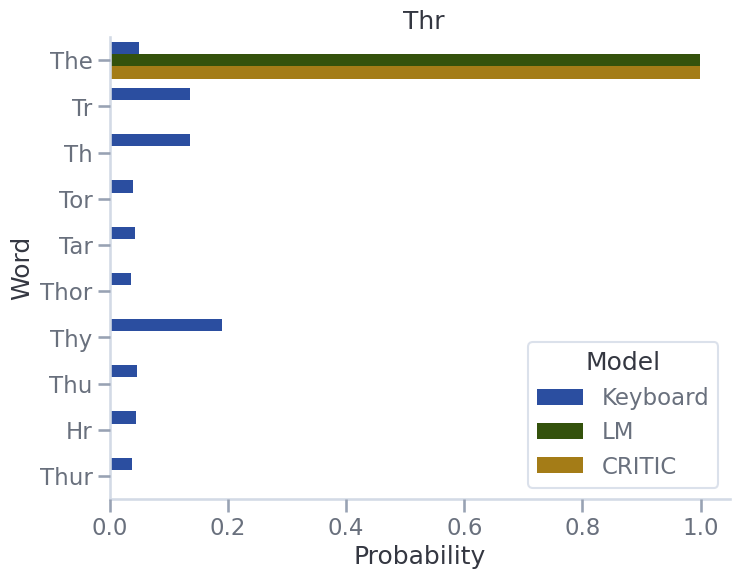

In [8]:
from copy import deepcopy


corrector = load_combo_corrector()


kbd_corrector = corrector.base
lm_corrector = load_combo_corrector()
lm_corrector.base = UniformCorrector()


context = ''
word = 'Thr'
# context = 'The coverage about me in the paper'
# word = 'gas'


corrector.push_words(context)
lm_corrector.push_words(context)

corrs = corrector.correct(word).as_series()
kbd_corrs = kbd_corrector.correct(word).as_series()
lm_corrs = lm_corrector.correct(word).as_series()


df = pd.DataFrame({'Keyboard': kbd_corrs, 'LM': lm_corrs, 'CRITIC': corrs}).reset_index(names='Word').sort_values('CRITIC', ascending=False).iloc[:10].melt(var_name='Model', value_name='Probability', id_vars=['Word'])

with sns.plotting_context('talk'):
    sns.barplot(df, x='Probability', y='Word', orient='h', hue='Model')
    plt.gca().set_title(f'{context} {word}')